# Simulated MVB

参考论文：<br>
https://www.researchgate.net/publication/6135459_Adaptive_Beamforming_Applied_to_Medical_Ultrasound_Imaging <br>
https://iopscience.iop.org/article/10.1088/1681-7575/aad146

### 1. 读取模拟钟组数据

In [1]:
import numpy as np
with open('simulated_data.npy', 'rb') as f:
    simulated_data = np.load(f)

In [2]:
print("Data shape: " + str(simulated_data.shape))  # 5 * (86400 * 30 -1)
print(simulated_data[0,:])

Data shape: (5, 2591999)
[9.32082767e-15 8.94900119e-15 8.60558999e-15 ... 1.09034894e-14
 1.05131087e-14 1.01126298e-14]


### 2. 使用MVB合成钟组

In [3]:
# https://allantools.readthedocs.io/en/latest/functions.html
!pip install allantools
import allantools

You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
y_t = simulated_data.T

In [5]:
subset_size = 3
clock_size = y_t.shape[1]

if subset_size > clock_size:
    raise Exception('The subset size should not be greater than the number of clocks')

------------------Step 0------------------
*** Raw sum ***
[2.79624830e-14 2.68470036e-14 2.58167700e-14 ... 3.15393262e-14
 3.03378895e-14 2.91357415e-14]
*** Raw sum ***
[2.79624830e-14 2.68470036e-14 2.58167700e-14 ... 3.15393262e-14
 3.03378895e-14 2.91357415e-14]
*** Raw sum ***
[2.79624830e-14 2.68470036e-14 2.58167700e-14 ... 3.15393262e-14
 3.03378895e-14 2.91357415e-14]
*** Cov mean ***
[[9.83669861e-30 9.83669861e-30 9.83669861e-30]
 [9.83669861e-30 9.83669861e-30 9.83669861e-30]
 [9.83669861e-30 9.83669861e-30 9.83669861e-30]]
*** Corr ***
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
*** Regularization term ***
[[1.96733972e-31 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96733972e-31 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96733972e-31]]
*** Inverse Cov mean ***
[[ 3.39989156e+30 -1.68311463e+30 -1.68311463e+30]
 [-1.68311463e+30  3.39989156e+30 -1.68311463e+30]
 [-1.68311463e+30 -1.68311463e+30  3.39989156e+30]]
*** Weight ***
[[0.33333333]
 [0.33333333]
 [0.3333333

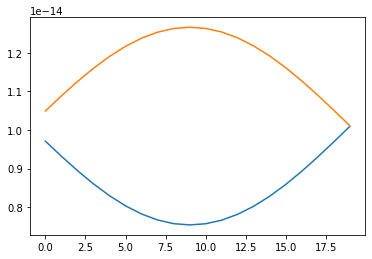

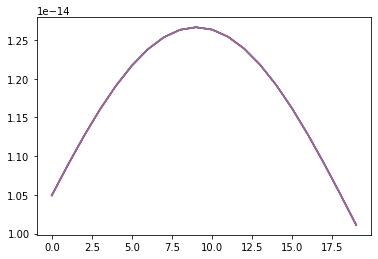

*** Weighted clock's Allan Variance ***
taus - [1. 2. 4.], adevs - [3.31945499e-17 6.97206538e-17 1.50329206e-16]
*** Mean clock's Allan Variance ***
taus - [1. 2. 4.], adevs - [3.31945499e-17 6.97206538e-17 1.50329206e-16]
*** Inverse variance weighted clock's Allan Variance ***
taus - [1. 2. 4.], adevs - [9.04545381e-25 2.28412294e-25 1.71629018e-25]
*** Each clock's Allan Variance ***
taus - [1. 2. 4.], adevs - [3.31945499e-17 6.97206538e-17 1.50329206e-16]
taus - [1. 2. 4.], adevs - [3.31945499e-17 6.97206538e-17 1.50329206e-16]
taus - [1. 2. 4.], adevs - [3.31945499e-17 6.97206538e-17 1.50329206e-16]
taus - [1. 2. 4.], adevs - [3.31945499e-17 6.97206538e-17 1.50329206e-16]
taus - [1. 2. 4.], adevs - [3.31945499e-17 6.97206538e-17 1.50329206e-16]


In [6]:
regularization = True
window_size = 86400*10
window_step = 86400
A = np.ones((clock_size - subset_size + 1, 1))

if window_size > y_t.shape[0]:
    raise Exception('The window size should not be greater than the number of time points')

weighted_clock_estimation = list()
weighted_inverse_variance_estimation = list()
for i in range(int((y_t.shape[0] - window_size) / window_step) + 1):
    subset_raw_sum_list = list()
    print("------------------Step %s------------------" % i)
    for j in range(y_t.shape[1] - subset_size + 1):
        # 1. Get raw subset
        subset_raw = y_t[i:i+window_size,j:j+subset_size]
        
        # 2. Calculate summation within a subset 
        subset_raw_sum = np.sum(subset_raw, axis=1)
        subset_raw_sum_list.append(subset_raw_sum)
        print("*** Raw sum ***")
        print(subset_raw_sum) 

    # 3. Calculate covariance matrix mean (Element-wise)
    print("*** Cov mean ***")
    allset_cov_mean = np.cov(np.asarray(subset_raw_sum_list)) / (clock_size - subset_size + 1)
    print(allset_cov_mean)
    print("*** Corr ***")
    allset_corr_mean = np.corrcoef(np.asarray(subset_raw_sum_list))
    print(allset_corr_mean)
    
    # 4. Add regularization term
    if regularization:
        print("*** Regularization term ***")
        sigma = np.max(allset_cov_mean) / (clock_size * 10.0)
        print(sigma * np.eye(clock_size - subset_size + 1))
        allset_cov_mean += sigma * np.eye(clock_size - subset_size + 1)
    
    
    # 5. Calculate the inverse of covariance matrix mean
    print("*** Inverse Cov mean ***")
    allset_cov_mean_inverse = np.linalg.inv(allset_cov_mean)
    print(allset_cov_mean_inverse)
    
    # 6. Calculate weight
    print("*** Weight ***")
    weight = np.dot(allset_cov_mean_inverse, A) / np.dot(np.dot(A.T, allset_cov_mean_inverse), A)
    print(weight)

    # 7. Calculate beamformer weighted clock
    print("*** Weighted output ***")
    Z = (np.dot(weight.T, np.asarray(subset_raw_sum_list)) / (clock_size - subset_size + 1))[0]
    print(Z)
    
    # 8. Select the last element in Z as the estimation of weighted clock
    weighted_clock_estimation.append(Z[-1])
    
    # 9. Calculate allan variance for each clock
    inverse_variance = list()
    clock_last_row = list()
    for k in range(clock_size):
        clock = y_t[window_step * i:window_step * i + window_size + 1, k]
        (taus, adevs, errors, ns) = allantools.adev(clock)
        inverse_variance.append(1.0 / adevs[0])
        clock_last_row.append(clock[-1])
    inverse_variance = np.array(inverse_variance) / np.sum(np.array(inverse_variance))
    print("*** Inverse variance weight ***")
    print(inverse_variance)
    
    # 10. Calculate the inverse variance weighted clock
    weighted_inverse_variance_clock = np.dot(inverse_variance, np.array(clock_last_row))
    print("*** Inverse variance weighted clock ***")
    print(weighted_inverse_variance_clock)
    weighted_inverse_variance_estimation.append(weighted_inverse_variance_clock)
    
# 11. Visualize weighted clock estimation and each clock
print("------------------Overall------------------")
print("*** Weighted clock estimation ***")
print(weighted_clock_estimation)

print("*** Inverse variance weighted clock estimation ***")
print(weighted_inverse_variance_estimation)

real_clock = y_t[-(int((y_t.shape[0] - window_size) / window_step) + 1):,]
real_clock_mean = np.mean(real_clock, axis=1)
print("*** Mean clock estimation ***")
print(real_clock_mean)

print("*** Clock covariance matrix ***")
print(np.cov(real_clock.T))

print("*** Clock corr matrix ***")
print(np.corrcoef(real_clock.T))

fig = plt.figure(facecolor='white')
plt.plot(weighted_clock_estimation)
plt.plot(real_clock_mean)
plt.show()

fig = plt.figure(facecolor='white')
plt.plot(real_clock)
plt.show()

# 12. Calculate Allan variance
print("*** Weighted clock's Allan Variance ***")
(taus, adevs, errors, ns) = allantools.adev(weighted_clock_estimation)
print('taus - %s, adevs - %s' % (taus, adevs))

print("*** Mean clock's Allan Variance ***")
(taus, adevs, errors, ns) = allantools.adev(real_clock_mean)
print('taus - %s, adevs - %s' % (taus, adevs))

print("*** Inverse variance weighted clock's Allan Variance ***")
(taus, adevs, errors, ns) = allantools.adev(weighted_inverse_variance_estimation)
print('taus - %s, adevs - %s' % (taus, adevs))

print("*** Each clock's Allan Variance ***")
for i in range(real_clock.shape[1]):
    (taus, adevs, errors, ns) = allantools.adev(real_clock[:,i])
    print('taus - %s, adevs - %s' % (taus, adevs))